В корне с файлом создаем папку "dataset". После скачивания [Simpsons Dataset](https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset?resource=download) кладем все в эту папку. Из основного после выполненных действий:
1. нам понадобятся данные для обучения, которые представлены в папке "simpsons_dataset" и имеют следующую структуру:
    - classname_1:
        - pic_{pic_number}.jpg
        - pic_{pic_number+1}.jpg
        - pic_n.jpg
    - classname_2:
        - pic_{pic_number}.jpg
        - pic_{pic_number+1}.jpg
        - pic_n.jpg
    - ...
    - classname_n:
        - pic_{pic_number}.jpg
        - pic_{pic_number+1}.jpg
        - pic_n.jpg
2. затем понадобятся данные для теста обучения, которые находятся в папке "kaggle_simpson_testset", которые имеют следующую структуру:
    - classname{name1}-label_{instance_1}.jpg
    - classname{name1}-label_{instance_2}.jpg
    - classname{name2}-label_{instance_1}.jpg
    - classname{name2}-label_{instance_2}.jpg
    - ...
    - classname{namen}-label_{instance_n}.jpg    
    
Так структура в пункте 2 не похожа на структуру из пункта 1, для единообразия нужно сделать ее похожей, для этого необходимо сначала запустить **testset_modify.py**

## Основной код обучения

In [1]:
import os
import time
import glob

from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision.models import resnet18, mobilenet

from IPython.display import clear_output
%matplotlib inline

from sklearn.model_selection import train_test_split

sns.set(font_scale=1.2)
sns.set_style(style='dark')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Устройство: {device}')
print(f'Версия pytorch: {torch.__version__}')

Устройство: cuda
Версия pytorch: 2.3.0.dev20240105+cu121


In [3]:
# разделим картинки на train и val в отношении 70 на 30 для каждого класса
data_dir = "./dataset/simpsons_dataset"
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split('/')[-2] for path in data_image_paths]
train_files_path, val_files_path = train_test_split(
    data_image_paths, 
    test_size=0.3,
    stratify=data_image_labels
)

print(
    f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}"
)

input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.RandomEqualize(),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(0.9, 0.9, 0.9),
    #transforms.Grayscale(),
    transforms.RandomAffine(15),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

Изображений в train: 14653
Изображений в val: 6280
Количество классов в train:  42
Количество классов в val:  42
Количество классов одинаково:  True


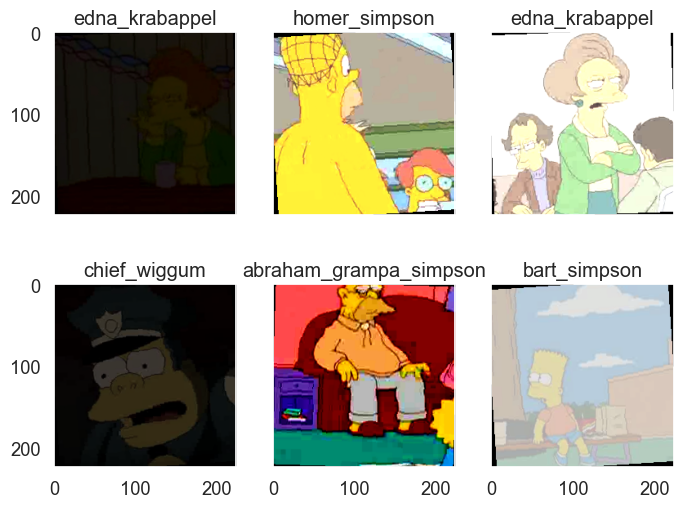

In [5]:
show_images(train_dataset)

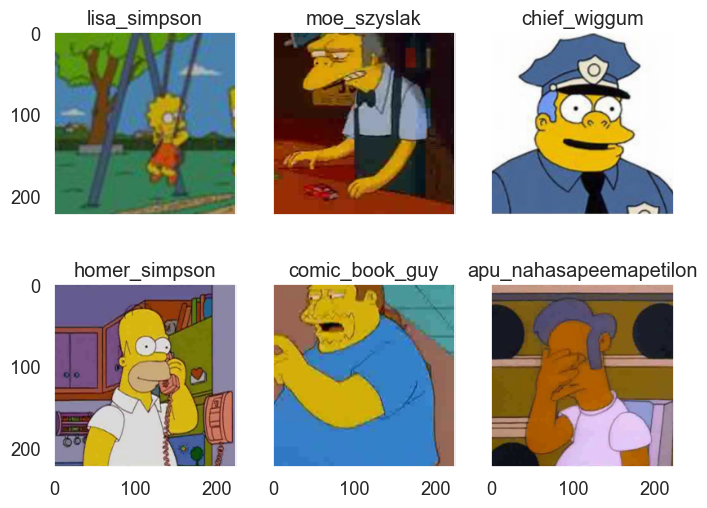

In [6]:
show_images(val_dataset)

In [4]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=10,
    scheduler=None

):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # полностью проходим по валидационному датасету  
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        if scheduler != None:
            scheduler.step()

        plot_learning_curves(history)
        
    return model, history

batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

Epoch 15 of 15 took 406.549s
  training loss (in-iteration): 	0.770233
  validation loss (in-iteration): 	0.860168
  training accuracy: 			79.34 %
  validation accuracy: 			77.24 %


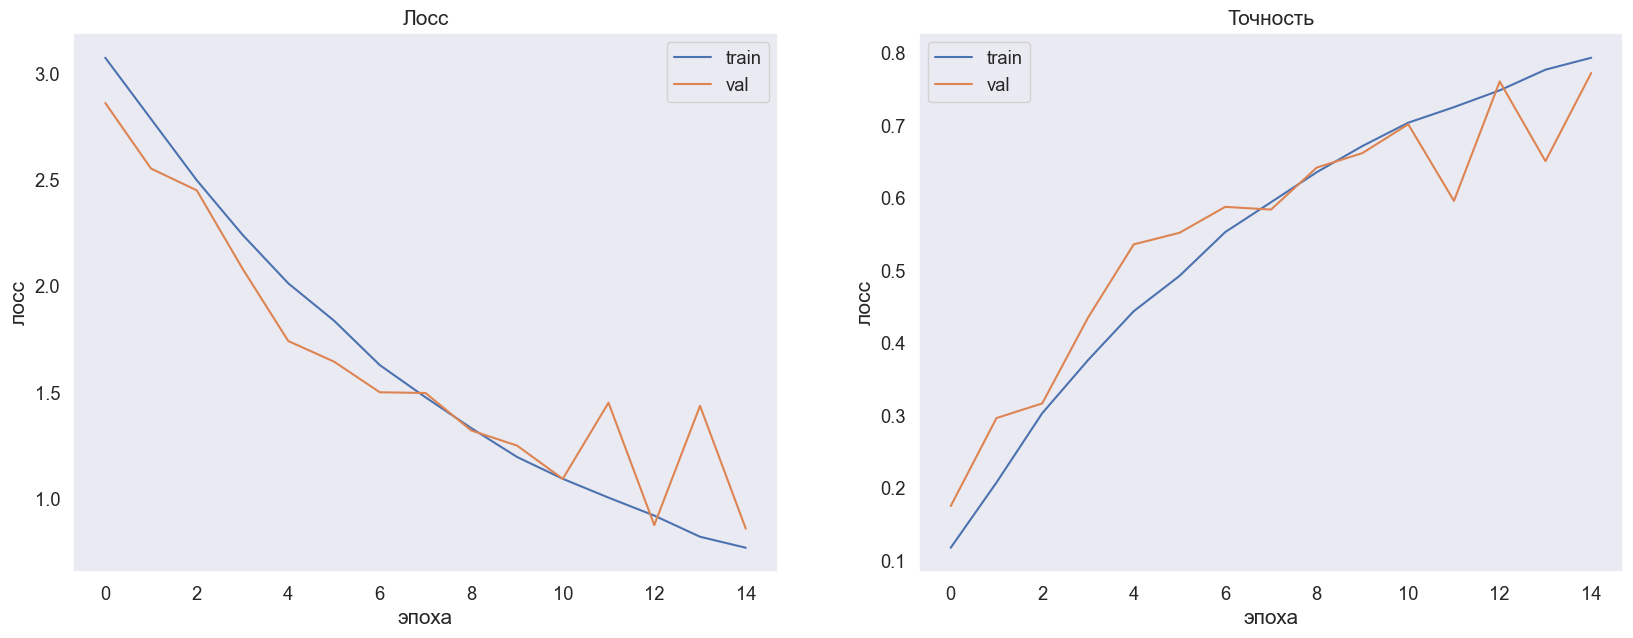

In [7]:
model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)

clf_model, history = train(
    model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=15
)

# Получение состояния модели
model_state = model.state_dict()

# Путь к файлу для сохранения весов
weights_path = "no_predtrained_weights"

# Сохранение весов в файл
torch.save(model_state, weights_path)

Epoch 15 of 15 took 244.069s
  training loss (in-iteration): 	1.453458
  validation loss (in-iteration): 	1.289986
  training accuracy: 			62.37 %
  validation accuracy: 			67.38 %


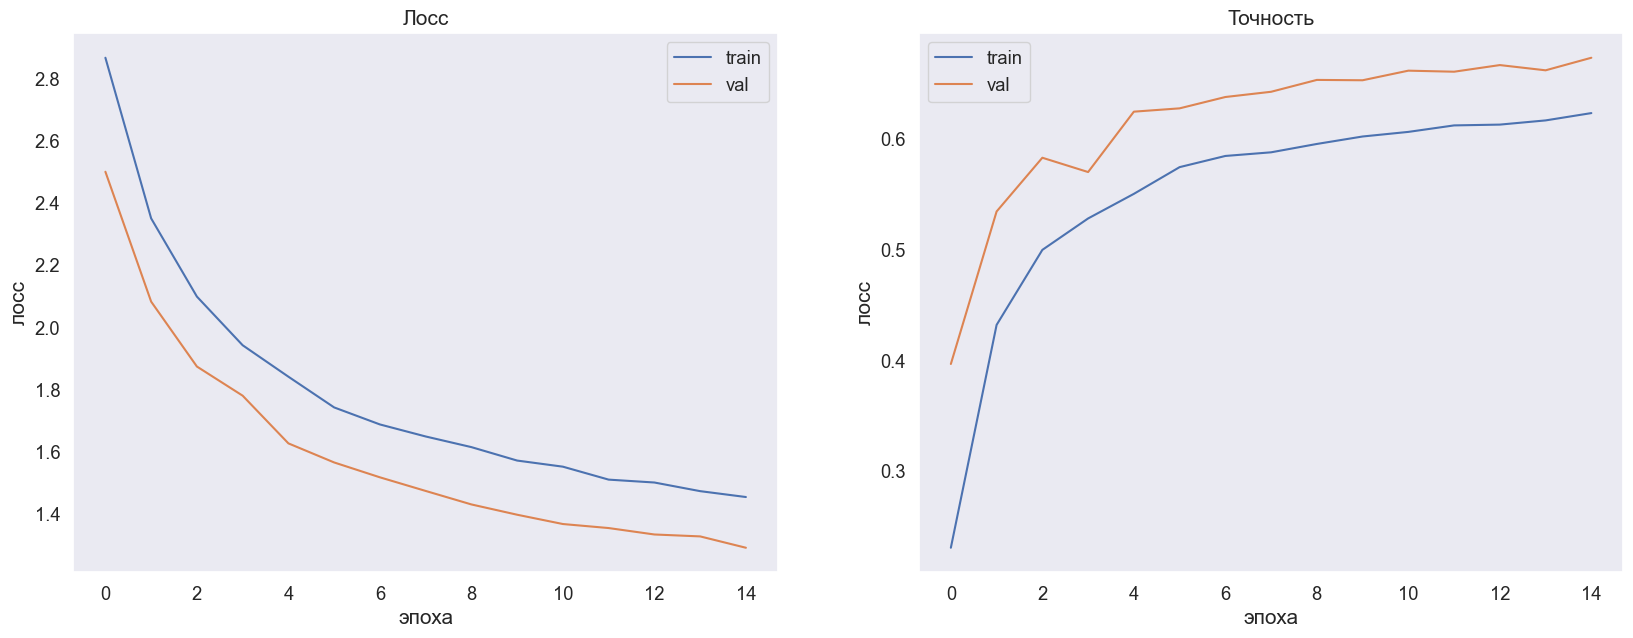

In [8]:
# возьмём предобученную сеть
fe_model = resnet18(pretrained=True)

# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model.fc = nn.Linear(512, 42)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01)

clf_model, history = train(
    fe_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=15
)

# Получение состояния модели
model_state = model.state_dict()

# Путь к файлу для сохранения весов
weights_path = "predtrained_weights"

# Сохранение весов в файл
torch.save(model_state, weights_path)

Epoch 15 of 15 took 390.367s
  training loss (in-iteration): 	0.038877
  validation loss (in-iteration): 	0.214121
  training accuracy: 			99.07 %
  validation accuracy: 			94.95 %


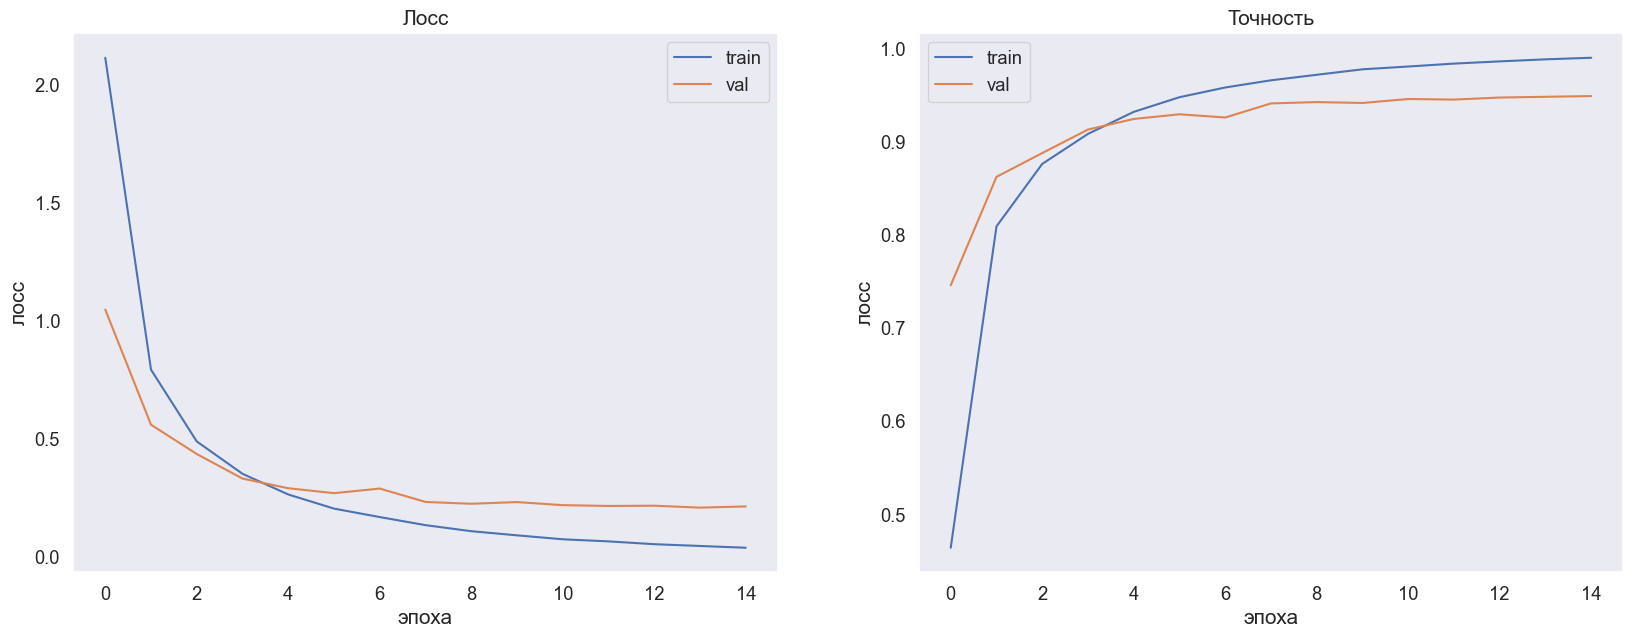

In [9]:

fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('resnet', resnet18(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

clf_model, history = train(
    fine_tuning_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=15
)

# Получение состояния модели
model_state = model.state_dict()

# Путь к файлу для сохранения весов
weights_path = "fine_tuning_weights"

# Сохранение весов в файл
torch.save(model_state, weights_path)

## Использование LR scheduler

### StepLR

Epoch 15 of 15 took 418.308s
  training loss (in-iteration): 	0.066201
  validation loss (in-iteration): 	0.351509
  training accuracy: 			98.55 %
  validation accuracy: 			91.10 %


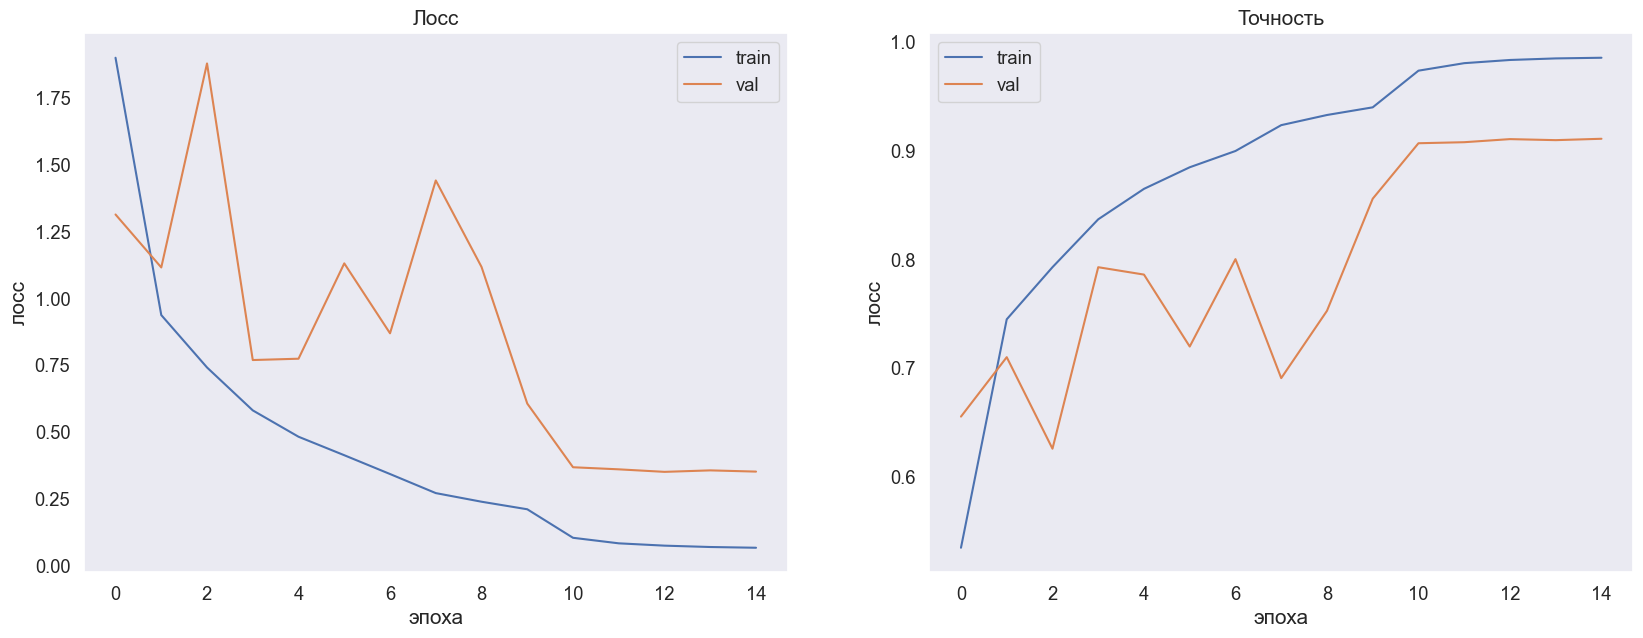

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Создание планировщика learning rate
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

clf_model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen, 
    num_epochs=15, scheduler=scheduler
)

# Получение состояния модели и сохранение весов
model_state = model.state_dict()
weights_path = "stepLR_no_pretrained_weights"
torch.save(model_state, weights_path)

### CosinerLR

Epoch 15 of 15 took 396.764s
  training loss (in-iteration): 	0.029002
  validation loss (in-iteration): 	0.371202
  training accuracy: 			99.41 %
  validation accuracy: 			91.05 %


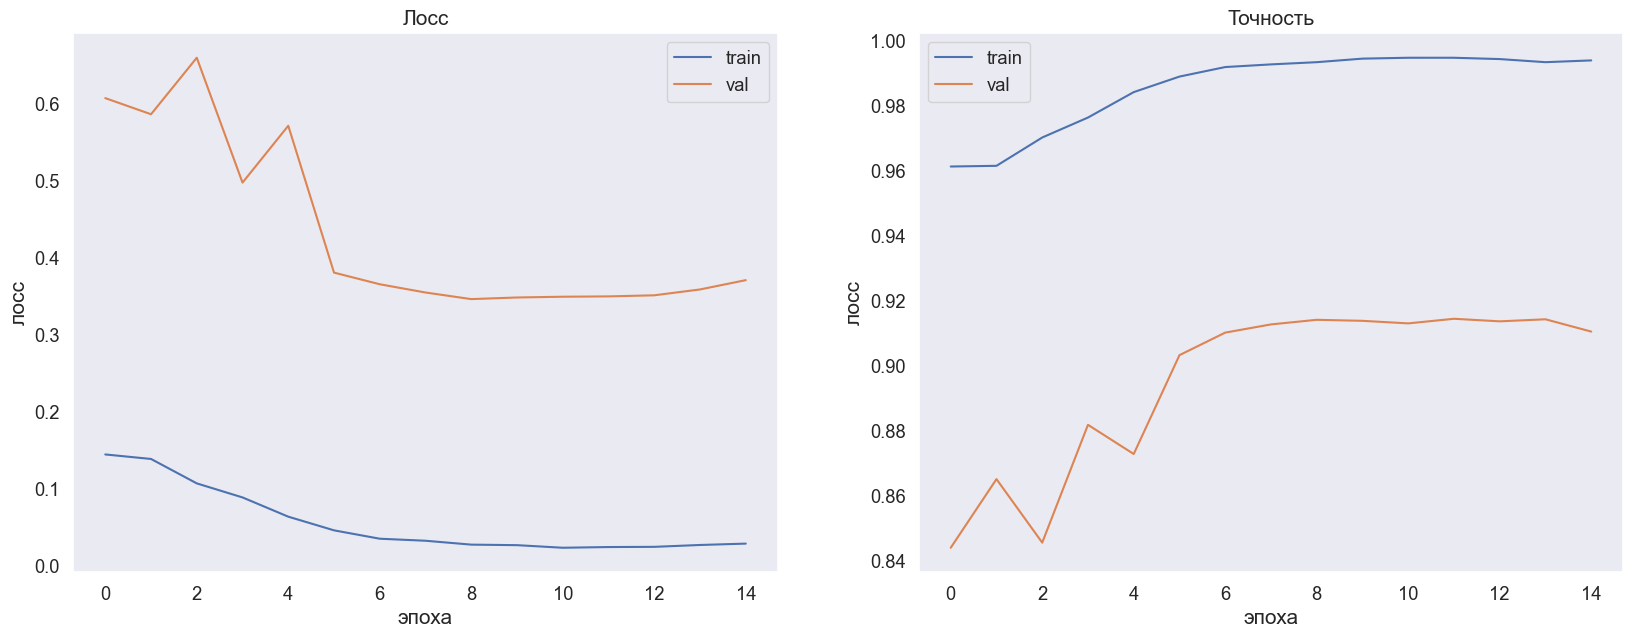

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Создание планировщика learning rate
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

clf_model, history = train(
    model, criterion, optimizer, scheduler,
    train_batch_gen, val_batch_gen, 
    num_epochs=15, scheduler=scheduler
)

# Получение состояния модели и сохранение весов
model_state = model.state_dict()
weights_path = "cosinerLR_no_pretrained_weights"
torch.save(model_state, weights_path)

# Аугментация
[Варианты транформации изображений](https://pytorch.org/vision/main/transforms.html). Также можно посмотреть [илюстрацию преобразований](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py). Из перечисленных вариантов, для решения данной задачи классификации можно выделить как полезные, с помощью которых можно "раздуть" датасет, так и те, которые навердят, но также есть и ситуативные, которые при небольшом изменении постановки задачи, могу повысить качество.    

К полезным можно отнести:
1. RandomHorizontalFlip - отзеркаливание изображение влево-вправо не навредит
2. RandomZoomOut - изображение разного размера, тоже неплохо
3. RandomRotation (только определенный диапазон +-30-45 градусов) - ситуативный вариант, при базовой постановки, 30-45 гадусов поворота не должно навредить
4. RandomAffine - примерно то же самое, что и п.3
5. RandomPerspective - определенные значение перспективы, также немного позволят повысить вариативность
6. RandomEqualize - небольшое изменение цветовых характеристик не сильно повлияет, так как картинка может быть разной насыщенности    

К негативным для данной задачи можно отнести:
1. ElasticTransform - так как классификация происходит по нарисованным персонажам, где важна четкость и точность контуров
2. RandomCrop - так как при неточном вырезании, может быть вырезана не важная для классификации часть, что приведет к "запутыванию" нейросети при обучении
3. RandomResizedCrop - по той же причине, что и в п.2, но еще больше может снизить качество
4. AugMix - размазывает контуры    

В зависимости от постановки могут быть как позитивными, так и негативными:
1. Grayscale - только при допущении, что картинка может быть черно белой, однако в симпсонах вроде как важна цветовая палитра
2. ColorJitter - если рассматриваются только базовые варианты симпсонов, но при базовой постановки больше вреда
3. RandomInvert - в целом то же самое, что и пп. 1-2
4. RandomSolarize - то же самое, что и п.3


Epoch 15 of 15 took 493.725s
  training loss (in-iteration): 	3.119298
  validation loss (in-iteration): 	3.280832
  training accuracy: 			10.33 %
  validation accuracy: 			6.55 %


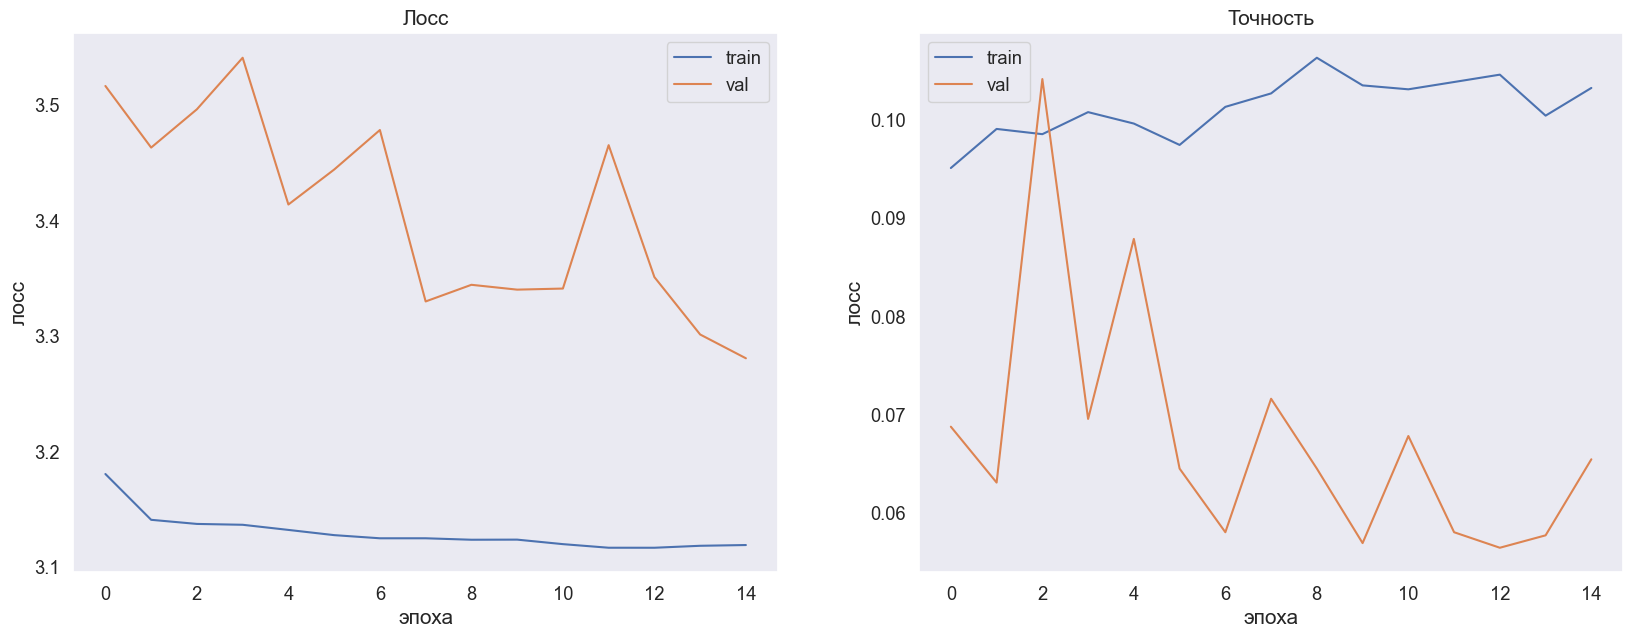

In [13]:
bad_train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(10.9, 10.9, 10.9), # пересвеченные/затемненные
    transforms.RandomAffine(90),
    transforms.Grayscale(3), # игра с цветом
    transforms.RandomInvert(1),
    transforms.RandomSolarize(11),
    transforms.ElasticTransform(float(500), float(1), fill=100), # кривые контуры
    #transforms.RandomCrop(50), # чтоб вообще было не понятно что это
    transforms.RandomResizedCrop(50),
    #transforms.AugMix(10, 30, -10, 10),
    transforms.RandomVerticalFlip(1),
    transforms.ToTensor(),
])

bad_train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=bad_train_transform,
    is_valid_file=lambda x: x in train_files_path
)

# не забудем перемешать train
bad_train_batch_gen = torch.utils.data.DataLoader(
    bad_train_dataset, batch_size=batch_size, shuffle=True
)

model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

clf_model, history = train(
    model, criterion, optimizer, 
    bad_train_batch_gen, val_batch_gen, 
    num_epochs=15
)

## Использование другой архитектуры

VGG, EfficientNet и MobileNet – это все популярные архитектуры сверточных нейронных сетей, используемые для компьютерного зрения и обработки изображений. Вот некоторые плюсы и минусы каждой из них:

### VGG:

<span style="color:green">Плюсы</span>:
- Простая и понятная архитектура сети.
- Имеет большое количество параметров, что может помочь в точности классификации изображений.

<span style="color:red">Минусы</span>:
- Очень глубокая сеть с большим количеством слоев, что требует больших вычислительных ресурсов и времени для обучения.
- Большое количество параметров может привести к переобучению.

### EfficientNet:

<span style="color:green">Плюсы</span>:
- Эффективная архитектура сети, которая достигает лучшей точности при меньшем количестве параметров.
- Масштабируемость: существуют различные версии EfficientNet – от B0 до B7, позволяющие выбрать необходимый баланс между точностью и вычислительной сложностью.

<span style="color:red">Минусы<span>:
- Обучение модели EfficientNet может занимать больше времени, чем у других архитектур.
-В некоторых случаях, более маленькие версии EfficientNet могут быть менее точными, чем более крупные.

### MobileNet:

<span style="color:green">Плюсы</span>:
- Легкая архитектура сети, которая работает хорошо на мобильных устройствах с ограниченными ресурсами.
- Быстрое обучение и инференс (вычисление предсказаний) благодаря меньшему количеству параметров.

<span style="color:red">Минусы</span>:
- Из-за своей легкости, MobileNet может быть менее точным, особенно при работе с сложными изображениями или задачами классификации с высоким уровнем детализации.
- Ограничения в производительности по сравнению с другими более сложными архитектурами.

В общем, выбор между VGG, EfficientNet и MobileNet зависит от ваших конкретных потребностей и ограничений по ресурсам. Если есть большие вычислительные ресурсы и требуется высокая точность, то VGG может быть хорошим выбором. Если - хороший баланс между точностью и вычислительной эффективностью, EfficientNet может подойти. Если нужна легкая модель для работы на мобильных устройствах или с ограниченными ресурсами, то MobileNet будет хорошим вариантом.

Итоговый выбор **MobileNet**, так как хочется исследовать точность на самой легкой CNN.

## Mobilenet своими силами

Epoch 20 of 20 took 236.645s
  training loss (in-iteration): 	0.818201
  validation loss (in-iteration): 	0.762019
  training accuracy: 			78.22 %
  validation accuracy: 			80.07 %


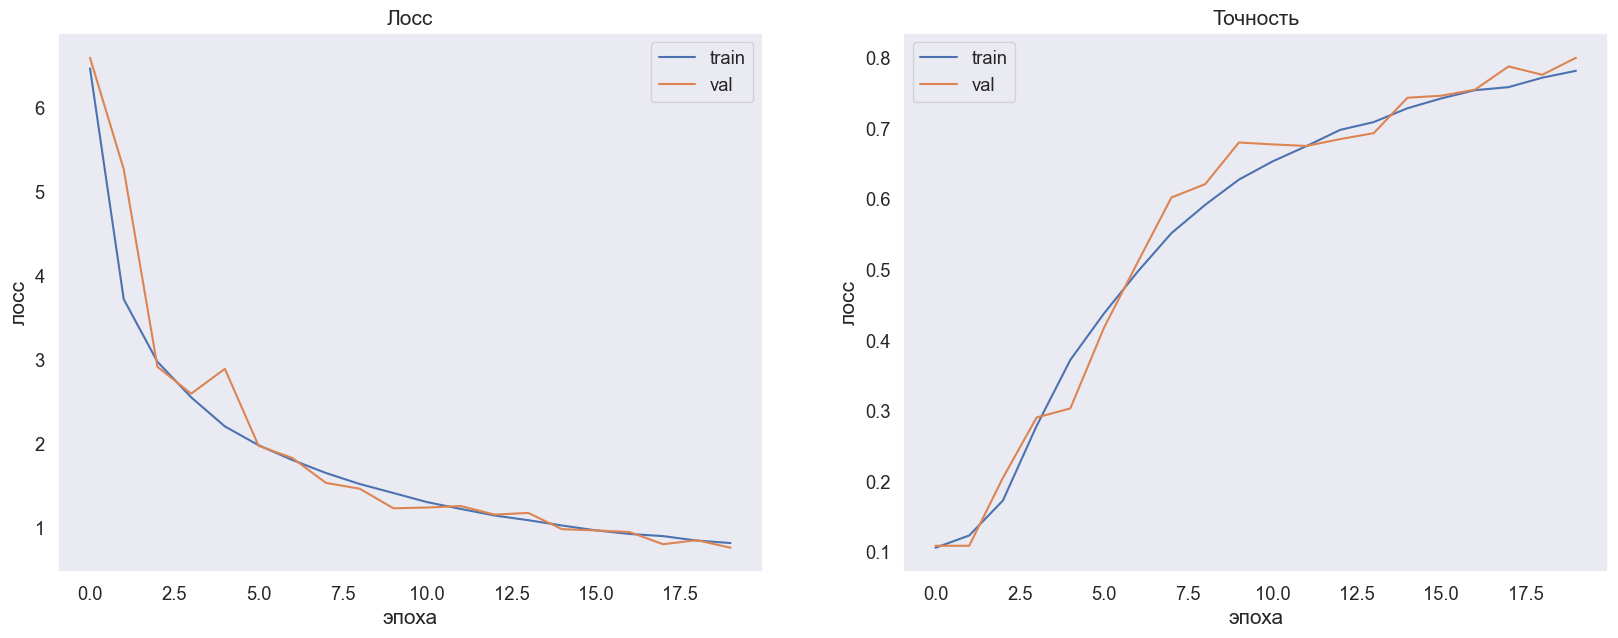

In [5]:
mobilenet_model = mobilenet.mobilenet_v3_small(pretrained=False)
mobilenet_model.fc = nn.Linear(512, 42)
mobilenet_model = mobilenet_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mobilenet_model.parameters(), lr=0.02)

clf_model, history = train(
    mobilenet_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=20
)

# Получение состояния модели
model_state = mobilenet_model.state_dict()

# Путь к файлу для сохранения весов
weights_path = "no_predtrained_weights_mobilenet"

# Сохранение весов в файл
torch.save(model_state, weights_path)

## Finetuning Mobilenet with CosinerLR

Epoch 10 of 10 took 706.062s
  training loss (in-iteration): 	0.017217
  validation loss (in-iteration): 	0.140457
  training accuracy: 			99.56 %
  validation accuracy: 			97.00 %


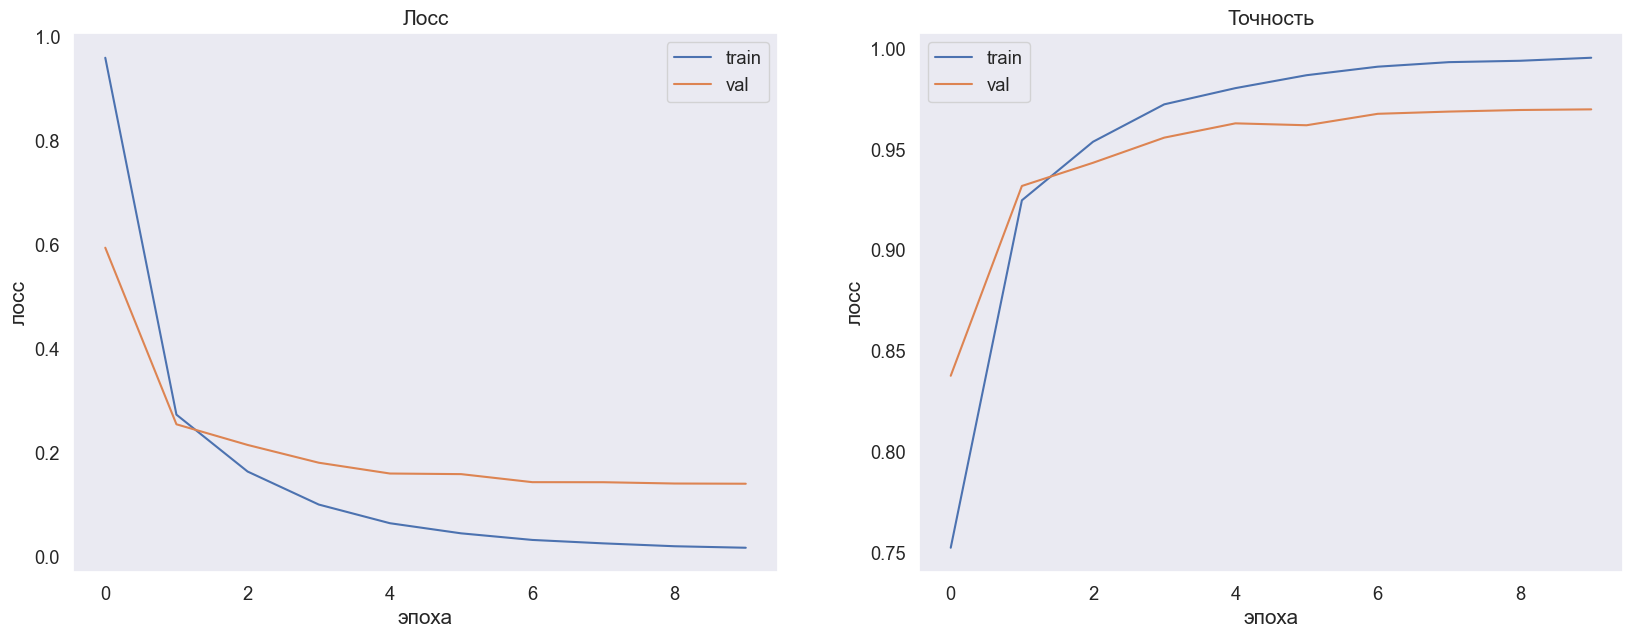

In [5]:
fine_tuning_mobilenet = nn.Sequential()

fine_tuning_mobilenet.add_module('mobilenet', mobilenet.mobilenet_v3_large(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_mobilenet.add_module('relu_1', nn.ReLU())
fine_tuning_mobilenet.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_mobilenet.add_module('relu_2', nn.ReLU())
fine_tuning_mobilenet.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_mobilenet = fine_tuning_mobilenet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_mobilenet.parameters(), lr=0.1)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

clf_model, history = train(
    fine_tuning_mobilenet, criterion, optimizer,
    train_batch_gen, val_batch_gen, 
    num_epochs=10, scheduler=scheduler
)

# Получение состояния модели
model_state = fine_tuning_mobilenet.state_dict()

# Путь к файлу для сохранения весов
weights_path = "fine_tuning_weights_finetuning_cosinerLR"

# Сохранение весов в файл
torch.save(model_state, weights_path)